# Constant Speed + Centerline

Algorithm: compute average speed over the past $n$ timesteps and follow a centerline at the computed speed.

Questions: how do you compute a trajectory from the end of the 2 second prior for the next 3 seconds that closely follows the chosen centerline(s)


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## A simple baseline

In [28]:
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.visualization.visualize_sequences import viz_sequence

In [13]:
##set root_dir to the correct path to your dataset folder
root_dir = '/home/aaron/workspace/argoverse/data/forecasting_test_v1.1/test_obs/data'

afl = ArgoverseForecastingLoader(root_dir)
atl = ArgoverseTrackingLoader(root_dir)
avm = ArgoverseMap()

print('Total number of sequences:',len(afl))

Total number of sequences: 78143


Let's say we have our (very very naive) prediction function;

Let's try that on our argoverse forecasting test set

In [49]:
trajectory = afl[10]

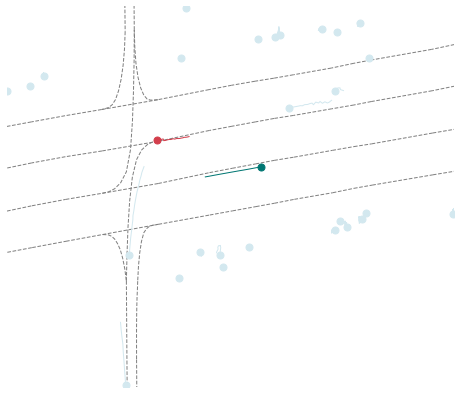

In [50]:
viz_sequence(trajectory.seq_df, show=True)

In [16]:
def prediction(trajectory,avm,city_name,num_points=30,avg_points=1):
    #a simple prediction function that predict straight line with constant velocity
    velocity_x_mps = []
    velocity_y_mps = []
    for i in range(1,avg_points+1,1):
        velocity_x_mps.append(trajectory[-i,0] - trajectory[-(1+i),0])
        velocity_y_mps.append(trajectory[-i,1] - trajectory[-(1+i),1])
        
    velocity_x_mps = np.mean(velocity_x_mps)
    velocity_y_mps = np.mean(velocity_y_mps)
    candidate_centerlines = avm.get_candidate_centerlines_for_traj(trajectory, city_name)
    print(candidate_centerlines)
    current_traj = trajectory[-1]
    results = np.zeros((len(trajectory)+num_points,2))
    
    results[0:len(trajectory)] = trajectory
    
    for i in range(num_points):
        results[len(trajectory)+i] = np.array([current_traj[0]+velocity_x_mps,current_traj[1]+velocity_y_mps])
        current_traj = results[len(trajectory)+i]
    return results

In [27]:
velocity_x_mps = []
velocity_y_mps = []
for i in range(1,avg_points+1,1):
    velocity_x_mps.append(trajectory[-i,0] - trajectory[-(1+i),0])
    velocity_y_mps.append(trajectory[-i,1] - trajectory[-(1+i),1])
velocity_x_mps = np.mean(velocity_x_mps)
velocity_y_mps = np.mean(velocity_y_mps)

In [27]:
candidate_centerlines = avm.get_candidate_centerlines_for_traj(trajectory, city_name)
print(candidate_centerlines)
current_traj = trajectory[-1]
results = np.zeros((len(trajectory)+num_points,2))

results[0:len(trajectory)] = trajectory

for i in range(num_points):
    results[len(trajectory)+i] = np.array([current_traj[0]+velocity_x_mps,current_traj[1]+velocity_y_mps])
    current_traj = results[len(trajectory)+i]
return results

[array([[-335.30463525, 3239.60136545],
       [-334.71523133, 3239.61761377],
       [-334.12582741, 3239.6338621 ],
       [-333.5364235 , 3239.65011043],
       [-332.94701958, 3239.66635876],
       [-332.35761566, 3239.68260709],
       [-331.76821175, 3239.69885542],
       [-331.17880783, 3239.71510374],
       [-330.58940392, 3239.73135207],
       [-330.        , 3239.7476004 ],
       [-330.        , 3239.7476004 ],
       [-329.53230841, 3239.76613371],
       [-329.06461681, 3239.78466702],
       [-328.59692522, 3239.80320033],
       [-328.12923362, 3239.82173365],
       [-327.66154203, 3239.84026696],
       [-327.19385043, 3239.85880027],
       [-326.72615884, 3239.87733358],
       [-326.25846724, 3239.89586689],
       [-325.79077565, 3239.9144002 ],
       [-325.79077565, 3239.9144002 ],
       [-324.92339588, 3239.9492601 ],
       [-324.05601612, 3239.98411999],
       [-323.18863635, 3240.01897989],
       [-322.32125659, 3240.05383978],
       [-321.45387683, 3

Here is an example of our prediction, initial trajectory in blue and the predicted trajectory in red

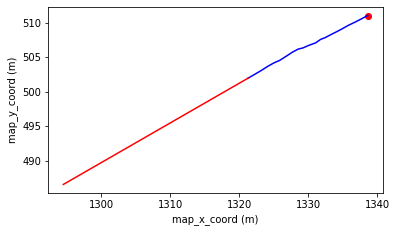

In [13]:
ax = plt.gca()
plt.plot(predict_traj[0,0],predict_traj[0,1],'-o',c='r') #starting point here
plt.plot(predict_traj[:21,0],predict_traj[:21,1],'-',c='b')
plt.plot(predict_traj[20:,0],predict_traj[20:,1],'-',c='r')

plt.xlabel('map_x_coord (m)')
plt.ylabel('map_y_coord (m)')
ax.set_aspect('equal')
plt.show()

Due to the multimodal nature of the problem, our challenge allows for (expects) multiple forecasts for each object.

For the purposes of this tutorial we will use different averaging windows to create multiple entries per object.

In [14]:
def get_multiple_forecasts(afl):
    predict_traj = []
    for i in range(9,3,-1):
        predict_traj.append(prediction(afl.agent_traj,avg_points=(i)))
    return np.array(predict_traj)

In [15]:
predict_traj = get_multiple_forecasts(afl)

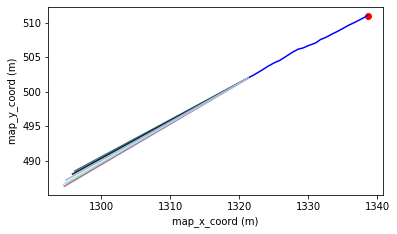

In [16]:
ax = plt.gca()

plt.plot(predict_traj[0,0,0],predict_traj[0,0,1],'-o',c='r') #starting point here
plt.plot(predict_traj[0,:21,0],predict_traj[0,:21,1],'-',c='b')

for i in range(len(predict_traj)):
    plt.plot(predict_traj[i,20:,0],predict_traj[i,20:,1],'-',c=np.random.rand(3,))
plt.xlabel('map_x_coord (m)')
plt.ylabel('map_y_coord (m)')
ax.set_aspect('equal')
plt.show()


## Compute all the results

In [17]:
output_all = {}
counter = 1
for data in afl:
    print('\r'+str(counter)+'/'+str(len(afl)),end="")
    predict_traj = get_multiple_forecasts(data)
    seq_id = int(data.current_seq.name[:-4])
    output_all[seq_id] = predict_traj[:,20:,:]
    counter += 1
    

3840/78143

KeyboardInterrupt: 

## Generate the result file

To participate in our competition, you need to upload the result file to our evaluation server on EvalAI https://evalai.cloudcv.org/. Make sure that your results are in the right format, and then call our helper function `generate_forecasting_h5`

In [ ]:
from argoverse.evaluation.competition_util import generate_forecasting_h5

output_path = 'competition_files/'

generate_forecasting_h5(output_all, output_path) #this might take awhile

25747/78143

You are all set!! 

Simply upload the output file `competition_files/argoverse_forecasting_baseline.h5` to our evaluation server on https://evalai.cloudcv.org/ and see how well you did it